### About
This notebook documents an analysis pipeline approach from the following paper and written in Python.

> *Spatiotemporal gene expression trajectories reveal development hierarchies of the human cortex* Nowakowski, et al., Science 358,
> 1318-1323 (2017)

### Author
Joshua Orvis (jorvis@gmail.com)

------------------

#### PCA

> Principal component analysis (PCA) was used to reduce the dimensionality of the dataset.

In the paper, this was N=40.  Can this be automated?

In [22]:
import os
os.chdir('/usr/local/projects/gEAR/cancer_dataset/')

import numpy as np
import scanpy.api as sc 

results_file = './fig1_analysis.h5ad'

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

adata = sc.read('fig1.tab', ext='txt', first_column_names=True).transpose()

adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

Per-cell normalize the data matrix, identify highly-variable genes and compute logarithm

normalizing by total count per cell
    finished (0:00:00.178): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
filter highly variable genes by dispersion and mean (0:00:00.113)
--> set `n_top_genes` to simply select top-scoring genes instead


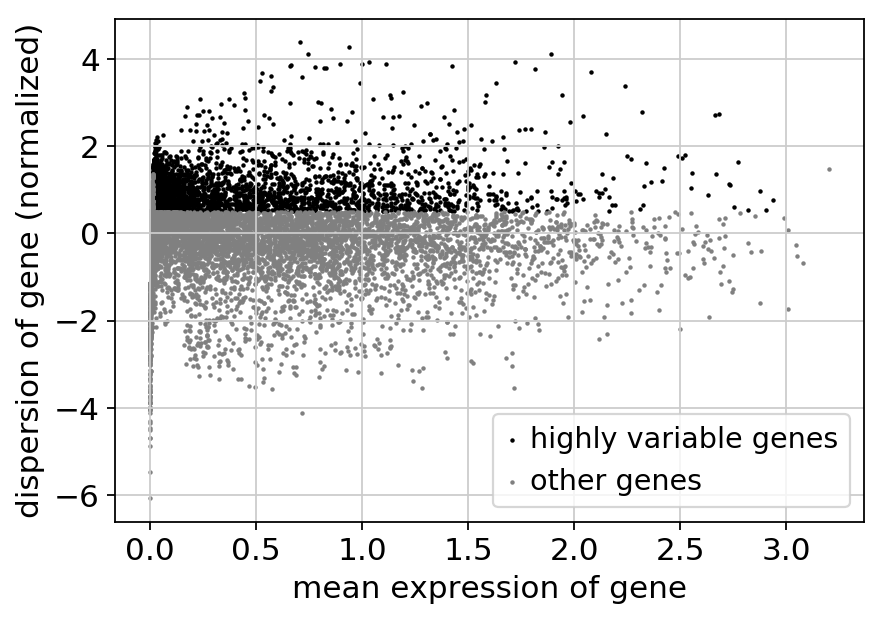

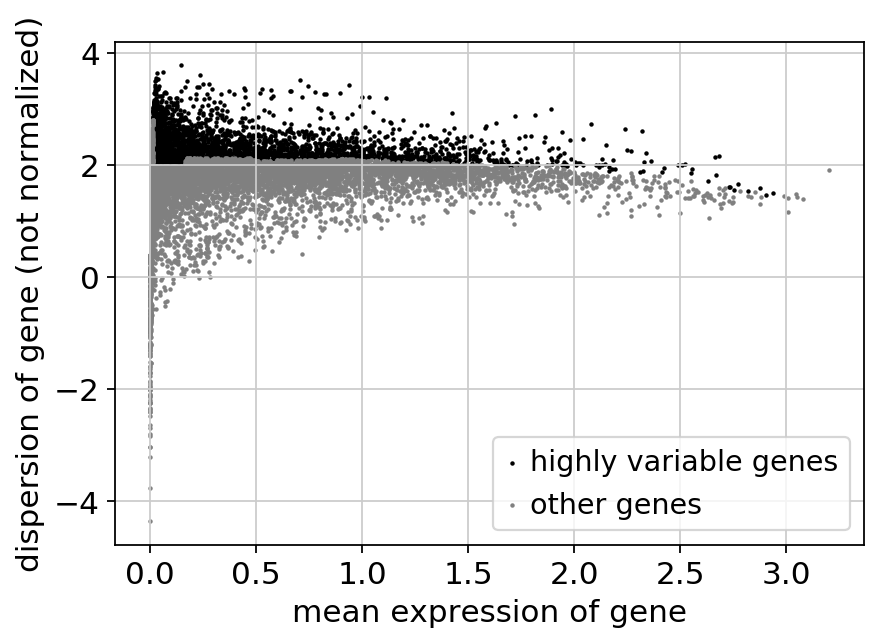

In [23]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.filter_genes_dispersion(filter_result)

Now actually do the filtering and logarithmize the data

In [24]:
fadata = adata[:, filter_result.gene_subset]
sc.pp.log1p(fadata)

Scale the data to unit variance

In [25]:
sc.pp.scale(fadata, max_value=10)

In [26]:
fadata.write(results_file)

Finally compute the PCA and make a scatter plot

In [27]:
sc.tl.pca(fadata)

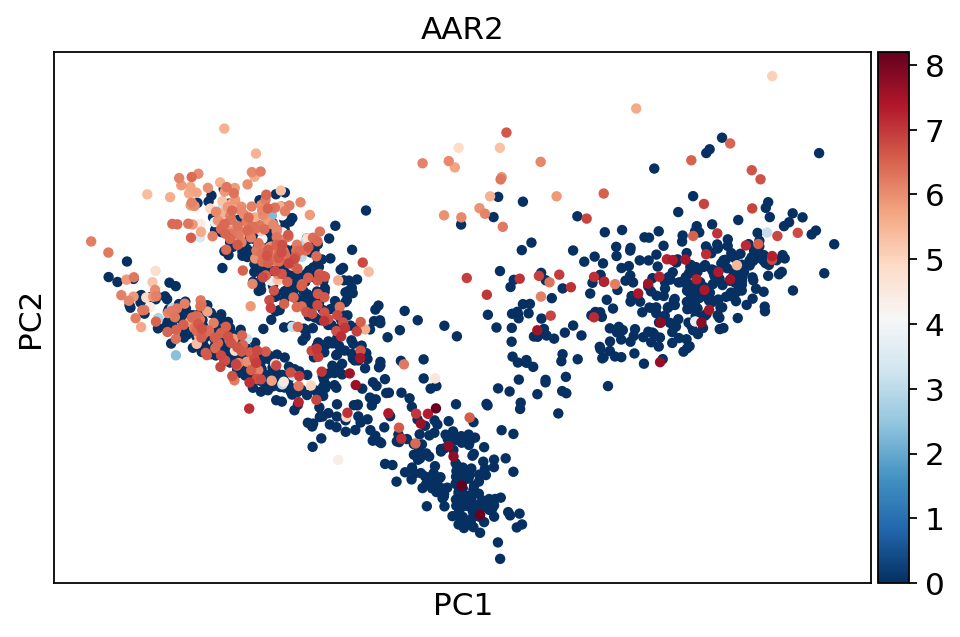

In [29]:
fadata.obsm['X_pca'] *= -1 # multiply by -= to match Seurat R
ax = sc.pl.pca_scatter(fadata, 'AAR2', right_margin=0.2)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). 

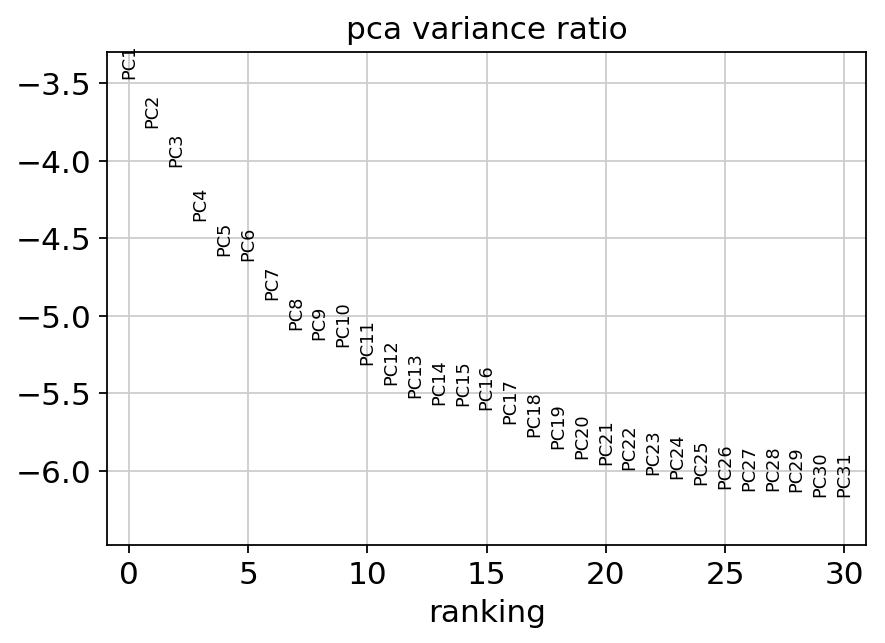

In [30]:
sc.pl.pca_variance_ratio(fadata, log=True)

### tSNE

In [31]:
adata = sc.read(results_file)

In [34]:
sc.tl.tsne(adata, n_pcs=8, random_state=2)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 8 for tSNE
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:05.256) --> added
    'X_tsne', tSNE coordinates (adata.obs)


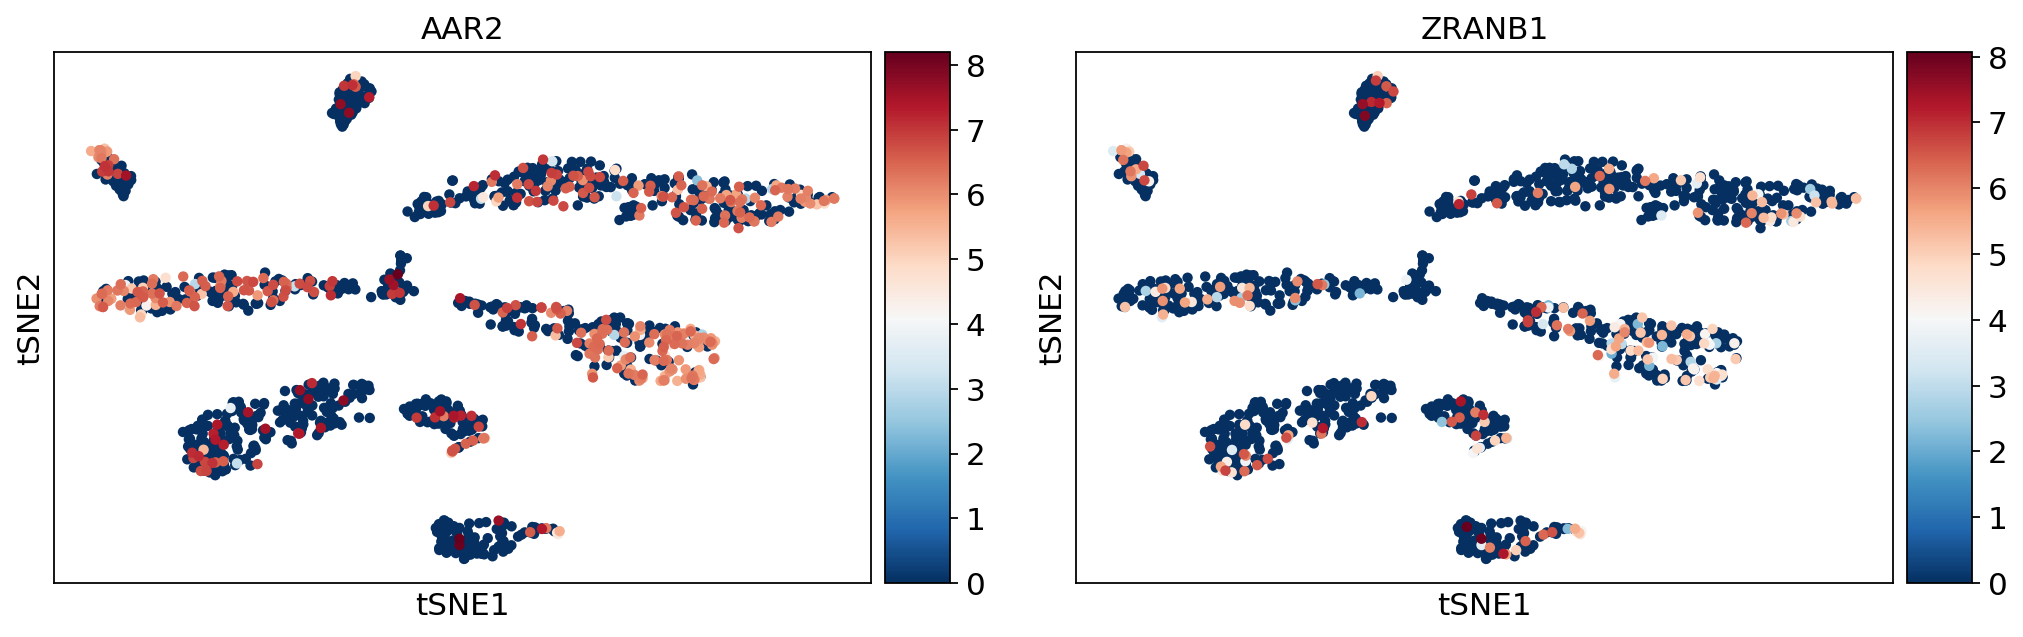

In [40]:
ax = sc.pl.tsne(adata, color=['AAR2', 'ZRANB1'], color_map='RdBu_r')

As we set the .raw attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression.
By setting use_raw to False, we can also plot the scaled and corrected expression.

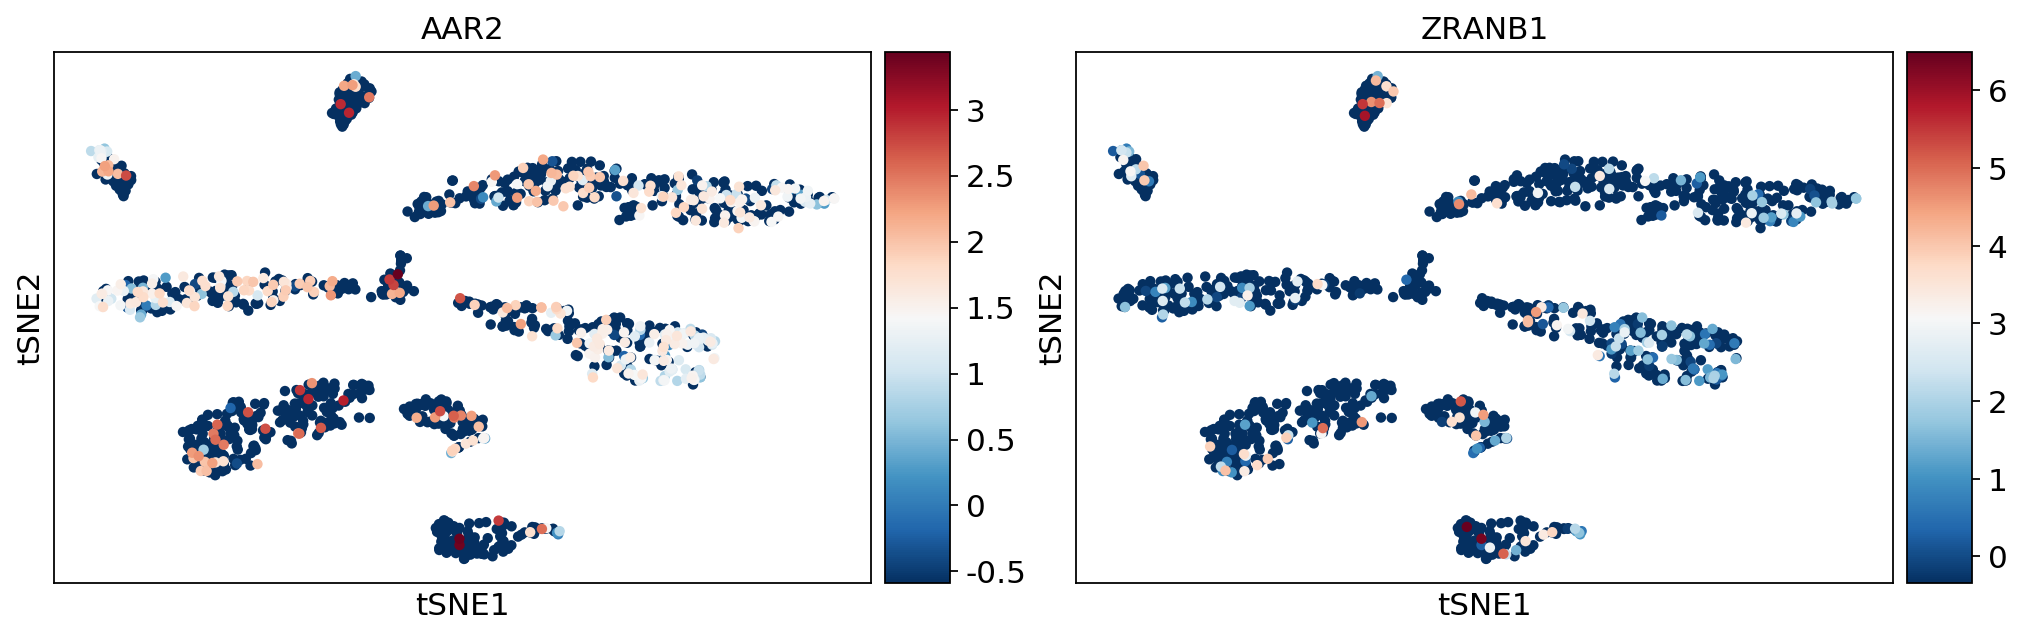

In [39]:
ax = sc.pl.tsne(adata, color=['AAR2', 'ZRANB1'], color_map='RdBu_r', use_raw=False)

### Clustering 

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015).

In [41]:
adata = sc.read(results_file)

In [42]:
sc.tl.louvain(adata, n_neighbors=7, resolution=1.3, recompute_graph=True)

running Louvain clustering
    compute 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 7 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [1.         0.9974594  0.9957709  0.99453884 0.99287784 0.99222267
     0.9906509  0.98529917 0.9807005  0.9774252  0.97544813 0.9719508
     0.95749646 0.9554355  0.9328279 ]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.602) --> found 18 clusters and added
    'louvain_groups', the cluster labels (adata.obs, dtype=category)


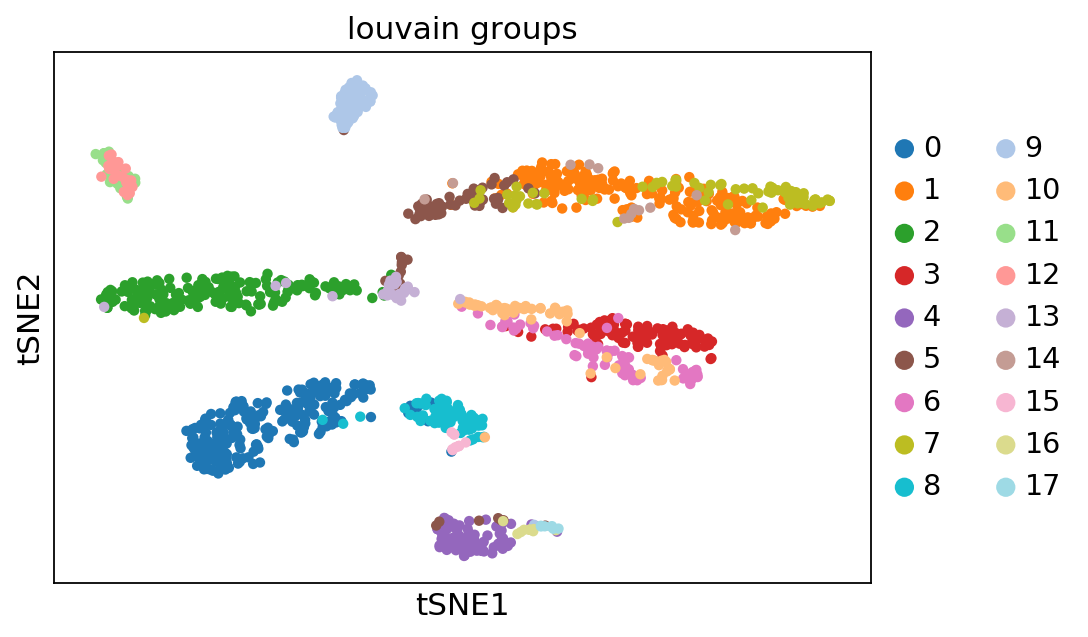

In [43]:
ax = sc.pl.tsne(adata, color='louvain_groups')

In [44]:
adata.write(results_file)

### Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes by z-score, this agrees quite well with the more advanced tests of Seurat.

rank differentially expressed genes
    consider 'louvain_groups': ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17'] with sample numbers [235 204 187 101  83  78  77  74  69  68  66  34  30  25  13  10   9   7]
    finished (0:00:00.925) --> added
    'rank_genes_groups_gene_names', np.recarray to be indexed by group ids (adata.uns)
    'rank_genes_groups_gene_scores', np.recarray to be indexed by group ids (adata.uns)
... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/rank_genes_groups_louvain_groups.pdf


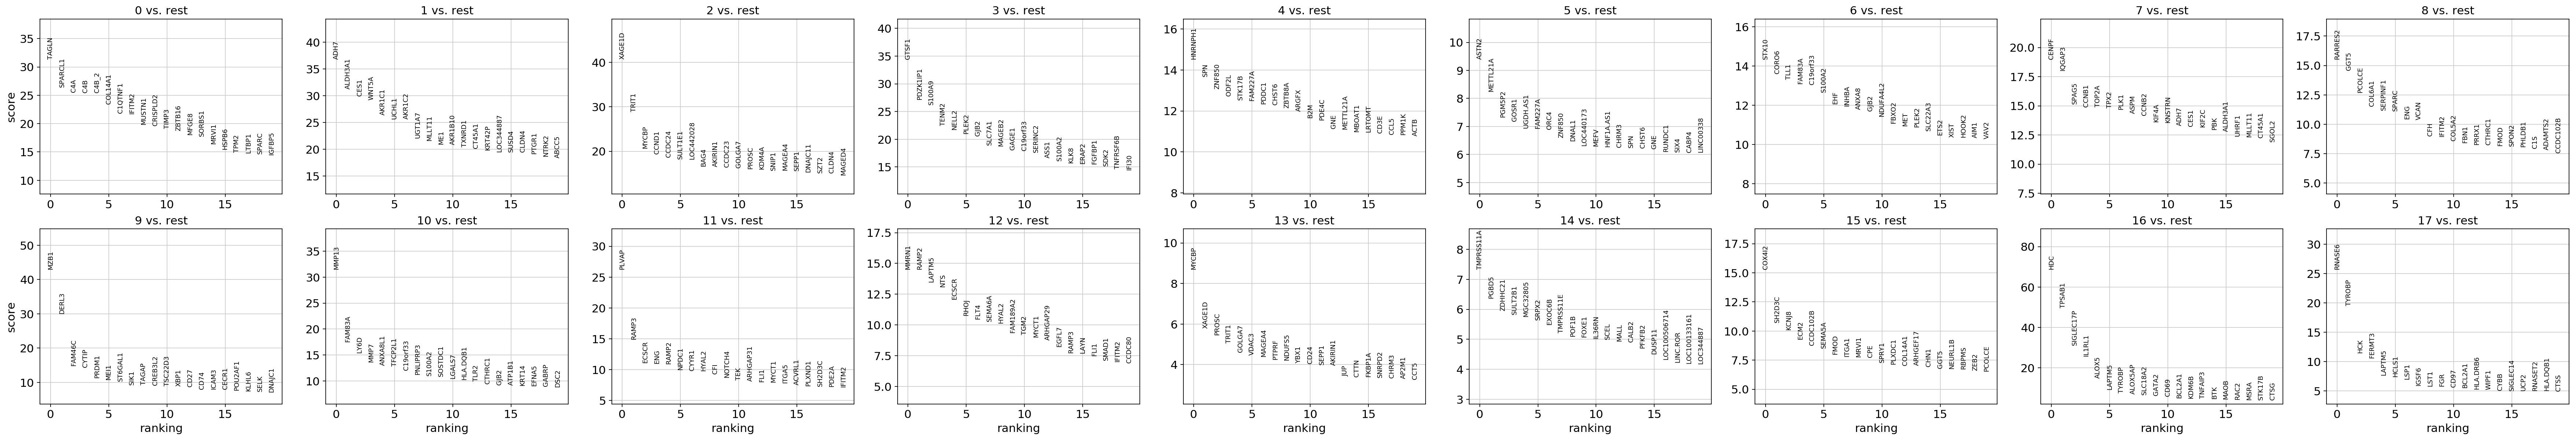

In [46]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain_groups')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

Show the 20 top ranked genes per cluster in a dataframe

In [47]:
import pandas as pd
pd.DataFrame(adata.uns['rank_genes_groups_gene_names']).loc[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,TAGLN,ADH7,XAGE1D,GTSF1,HNRNPH1,ASTN2,STX10,CENPF,RARRES2,MZB1,MMP13,PLVAP,MMRN1,MYCBP,TMPRSS11A,COX4I2,HDC,RNASE6
1,SPARCL1,ALDH3A1,TRIT1,PDZK1IP1,SPN,METTL21A,CORO6,IQGAP3,GGT5,DERL3,FAM83A,RAMP3,RAMP2,XAGE1D,PGBD5,SH2D3C,TPSAB1,TYROBP
2,C4A,CES1,MYCBP,S100A9,ZNF850,PGM5P2,TLL1,SPAG5,PCOLCE,FAM46C,LY6D,ECSCR,LAPTM5,PROSC,ZDHHC21,KCNJ8,SIGLEC17P,HCK
3,C4B,WNT5A,CCND1,TENM2,ODF2L,GOSR1,FAM83A,CCNB1,COL6A1,CYTIP,MMP7,ENG,NTS,TRIT1,SULT2B1,ECM2,IL1RL1,FERMT3
4,C4B_2,AKR1C1,CCDC24,NELL2,STK17B,UGDH.AS1,C19orf33,TOP2A,SERPINF1,PRDM1,ANXA8L1,RAMP2,ECSCR,GOLGA7,MGC32805,CCDC102B,ALOX5,LAPTM5
5,COL14A1,UCHL1,SULT1E1,PLEK2,FAM227A,FAM227A,S100A2,TPX2,SPARC,MEI1,TFCP2L1,NPDC1,RHOJ,VDAC3,SRPX2,SEMA5A,LAPTM5,HCLS1
6,C1QTNF1,AKR1C2,LOC442028,GJB2,PDDC1,ORC4,EHF,PLK1,ENG,ST6GAL1,C19orf33,CYYR1,FLT4,MAGEA4,EXOC6B,FMOD,TYROBP,LSP1
7,IFITM2,UGT1A7,BAG4,SLC7A1,CHST6,ZNF850,INHBA,ASPM,VCAN,SIK1,PNLIPRP3,HYAL2,SEMA6A,PTPRF,TMPRSS11E,ITGA1,ALOX5AP,IGSF6
8,MUSTN1,MLLT11,AKIRIN1,MAGEB2,ZBTB8A,DNAL1,ANXA8,CCNB2,CFH,TAGAP,S100A2,CFI,HYAL2,NDUFS5,POF1B,MRVI1,SLC18A2,LST1
9,CRISPLD2,ME1,CCDC23,GAGE1,ARGFX,LOC440173,GJB2,KIF4A,IFITM2,CREB3L2,SOSTDC1,NOTCH4,FAM189A2,YBX1,FOXE1,CPE,GATA2,FGR
